# <center><font color='red'><u>UMA-Tracker Analysis</u><font></center> 
## <center>This notebook file helps with the analysis of the output from [UMA-Tracker](https://ymnk13.github.io/UMATracker/)</center>  
The output is a comma-seperated file (csv) with the frame positions in the first column and alternating x- and y-positions in the additional columns as seen in the picture below. This analysis will obviously work for the result of any program as long as the needed csv-file is given.


![title](pics/example_csv.png)

### 1. First you have to specify the path to the csv-file from UMA-Tracker or any other program.
### 2. Then you can choose a colormap from matploblib. You can choose one [here](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html). These colors will represent your animals in the resulting graphs.
### 3. Additionally you have to enter the framerate of the tracked video, so that the graphs show the results in seconds and not frames. If you are using UMA-Tracker, you can find the framerate in the "info"-file

In [6]:
# Add the path to the filname here in quotes ("example.csv")
filename = "example_results.csv"
# Choose a colormap from matplotlib in qoutes (""). Two colormaps that are often used are "plasma" and "viridis"
colormap = "plasma"
# Add the framerate of the tracked video. If you are using UMA-Tracker, you can find it in the "info"-file
frame_rate = 24.417

### The next cell will import some python packages. If you get an import error you have to first install the packages. The easiest way to do this is using a [conda environment](https://www.anaconda.com/). 

### Additionally a directory will be create for the resulting graphs and the given file will be read into memory. If there is an error with reading the file, check if you have the right path and if the file looks like the picutre above.

In [10]:
# First a bunch of imports
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np
from itertools import groupby
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import seaborn as sn
import os
from scipy import stats, integrate
%matplotlib inline

# Set some variables for the analysis

pos_df = pd.read_csv(filename)
pos_df.set_index("position", drop=True, inplace=True)

if not os.path.exists('graphs'):
    os.makedirs('graphs')
if not os.path.exists('files'):
    os.makedirs('files')
short_fn = filename[:-4]


# <center><u>3-D Graphs</u></center>

## The next cell will make a 3-D graph of the movement of the mice. The x- and y-coordinates are the corresponding positions and the z-axis shows the time.

![example_3d](pics/example_3d.png)

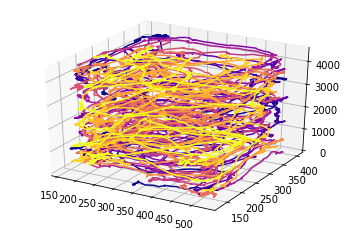

In [11]:
def make_threeD_graph(df_pos, colormap, fn):
    """Make a 3D Graph of the positions of the mice (x,y) over time (z)
       Give the Dataframe of the positions"""

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    min_pos = pos_df.min(axis=0).min()
    max_pos = pos_df.max(axis=0).max()

    # Make colors for each mouse
    colormap = cm.get_cmap(colormap)
    colors = colormap(np.linspace(0, 1, int(len(pos_df.columns)/2)))
    
    # for each mouse plot the line in the graph
    for mouse in range(round(len(pos_df.columns)/2)):
        ax.plot(xs=pos_df["x" + str(mouse)], ys=pos_df["y" + str(mouse)], zs=pos_df.index, c=colors[mouse])
    plt.savefig("graphs/" + fn + "_3d_graph.png")
    

make_threeD_graph(pos_df, colormap, short_fn)




# <center><u>Contact Graphs</u></center>

## The next graphs show the number and duration of contacts between the animals. You have to choose which distance in pixel still count as contact. If you are not sure just try some values between 20 - 100 and see which one works well.

## You can also choose what kind of graphs you would like. There is a pie graph, a stacked bar graph and a heatmap. You can also just create all graphs and then decide which one fits your purpose. To create the graphs set the value of the variable to True, else set it to False.

![example_pie](pics/example_contact_pie.png)
![example_stacked_bar](pics/example_contact_stack_bar.png)
![example_heatmap](pics/example_contact_heatmap.png)

In [12]:
distance_to_count_as_contact = 50
make_pie_graphs = True
make_stacked_bar_graphs = True
make_heatmaps = True

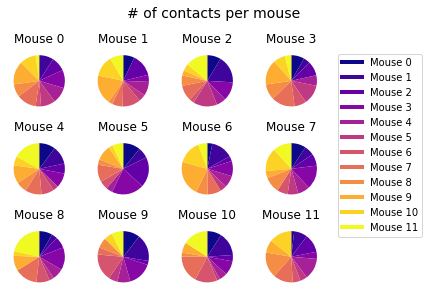

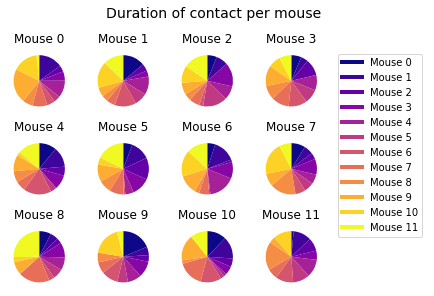

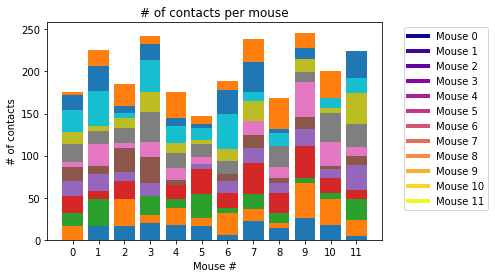

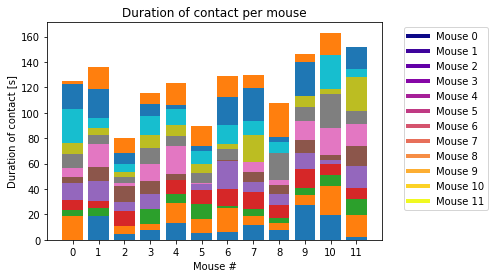

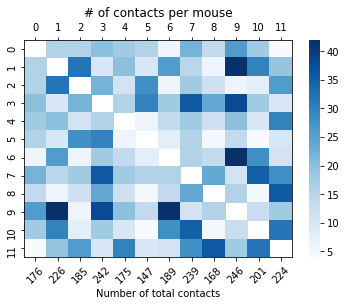

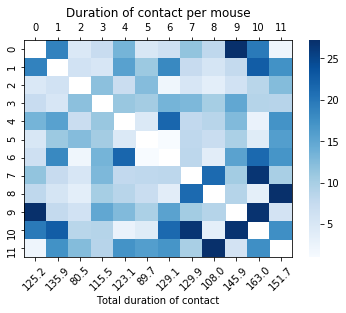

In [13]:
def calculate_contacts(pos_df, dist, fn, pie_chart, stacked_bar, heatmap, colormap):
    number_of_mice = round(len(pos_df.columns)/2)
    
    x_rows = pos_df[pos_df.columns[pos_df.columns.str.startswith('x')]]
    y_rows = pos_df[pos_df.columns[pos_df.columns.str.startswith('y')]]
    
    dist_dfs= [pd.DataFrame(index=x_rows.index, columns=[str(i) for i in range(number_of_mice)])
               for _ in range(number_of_mice)]
    for x1, y1, counter1 in zip(x_rows.columns, y_rows.columns,[i for i in range(number_of_mice)]):
        for x2, y2, counter2 in zip(x_rows.columns, y_rows.columns, [str(i) for i in range(number_of_mice)]):
            dist_dfs[counter1][counter2] = np.sqrt( (x_rows[x1]-x_rows[x2])**2 + (y_rows[y1]-y_rows[y2])**2)

    over_th_dfs = [dist_dfs[i] < dist for i in range(number_of_mice)]
    
    contact_counts_df = pd.DataFrame(index=[str(i) for i in range(number_of_mice)],
                                     columns=[str(i) for i in range(number_of_mice)])
    for i in range(number_of_mice):
        contacts_for_mice_i = []
        for j in range(number_of_mice):
            contacts_list = [list(group) for key, group in groupby(over_th_dfs[i][str(j)].values.tolist())]
            if len(contacts_list)%2 == 0:
                contacts = round(len(contacts_list)/2)
            else:
                first_is_true = contacts_list[0][0]
                
                contacts = round(len(contacts_list)-1/2)
                if first_is_true:
                    contacts += 1
            contacts_for_mice_i.append(contacts)
        contact_counts_df[str(i)] = contacts_for_mice_i
    np.fill_diagonal(contact_counts_df.values, 0)
    
    
    contact_duration_df = pd.DataFrame(index=[str(i) for i in range(number_of_mice)],
                                     columns=[str(i) for i in range(number_of_mice)])
    for i in range(number_of_mice):
        durations_for_mice_i = []
        for j in range(number_of_mice):
            frames_of_contact = over_th_dfs[i][str(j)].value_counts()
            
            durations_for_mice_i.append(frames_of_contact[True]/frame_rate)
        contact_duration_df[str(i)] = durations_for_mice_i
    np.fill_diagonal(contact_duration_df.values, 0)
    
    contact_counts_df.to_csv(f"files/{fn}_contact_counts.csv")
    contact_duration_df.to_csv(f"files/{fn}_contact_duration.csv")
    
    number_of_rows = int(number_of_mice**0.5)
    if number_of_mice%number_of_rows != 0:
        number_of_cols = int(number_of_mice/number_of_rows) + 1
    else:
        number_of_cols = round(number_of_mice/number_of_rows)
    
    dfs = [contact_counts_df, contact_duration_df]
    titles = ["# of contacts per mouse", "Duration of contact per mouse"]
    ylabels= ["# of contacts", "Duration of contact [s]"]
    output = ["contact_count", "contact_duration"]
    second_x_axis_title = ["Number of total contacts", "Total duration of contact"]
    round_number = [0,1]
    
    
    colormap = cm.get_cmap(colormap)
    colors = colormap(np.linspace(0, 1, number_of_mice))
    custom_lines = [Line2D([0],[0], color=colors[i], lw=4) for i in range(len(colors))]
    if pie_chart:
        for counter in range(2):
            fig1 = plt.figure(constrained_layout=True)
            gs1 = gridspec.GridSpec(ncols=number_of_cols + 1 , nrows=number_of_rows, figure=fig1)
            axes1 = []
            fig1.suptitle(titles[counter], fontsize=14)
            for i,j in enumerate(dfs[counter].columns):
                
                axes1.append(fig1.add_subplot(gs1[int(i/number_of_cols), i%number_of_cols]))
                axes1[-1].pie(dfs[counter][j], colors=colors, startangle=90, counterclock=False)
                axes1[-1].set_title(f"Mouse {i}")

            axes1.append(fig1.add_subplot(gs1[:, -1]))
            axes1[-1].axis('off')
            axes1[-1].legend(custom_lines, [f"Mouse {i}" for i in range(number_of_mice)])
            fig1.savefig(f"graphs/{fn}_{output[counter]}_pie.png")
           
    if stacked_bar:

        for counter in range(2):
            fig = plt.figure()
            
            sums = np.zeros(number_of_mice)
            ind = np.arange(number_of_mice)
            for i,j in enumerate(dfs[counter].index):
                plt.bar(ind, dfs[counter].loc[j], bottom=sums)
                sums += dfs[counter].loc[j]
            
            plt.xticks(ind, [i for i in range(number_of_mice)])
            plt.ylabel(ylabels[counter])
            plt.xlabel("Mouse #")
            plt.title(titles[counter])
            plt.legend(custom_lines, [f"Mouse {i}" for i in range(number_of_mice)], bbox_to_anchor=(1.05,1),
                       loc="upper left")
            plt.savefig(f"graphs/{fn}_{output[counter]}_stacked_bar.png")
    heatmap = True
    if heatmap:
        
        for counter in range(2):
            mask = [(i,i) for i in range(len(dfs[counter]))]
            fig = plt.figure()
            mask = np.zeros_like(dfs[counter], dtype=np.bool)
            np.fill_diagonal(mask, True)


            ind = np.arange(number_of_mice)
            ax = sn.heatmap(dfs[counter], cmap="Blues", mask=mask, xticklabels=[i for i in range(number_of_mice)],
                            yticklabels=[i for i in range(number_of_mice)])
            
            
            
            loc, lab = plt.xticks()
            ax2 = ax.twiny()
            ax.xaxis.tick_top()
            ax2.set_xticks(loc)

            ax2.set_xticklabels(dfs[counter].sum().round(round_number[counter]), rotation=45)
            ax2.set_xlim(0, number_of_mice)
            
            ax2.xaxis.set_ticks_position("bottom")
            ax2.set_xlabel(second_x_axis_title[counter])
            ax2.xaxis.set_label_position('bottom') 
            plt.title(titles[counter])

            plt.savefig(f"graphs/{fn}_{output[counter]}_heatmap.png")



calculate_contacts(pos_df, distance_to_count_as_contact,short_fn, True, True, True, colormap)

# <u><center>Distance bar graph</center></u>
## In the next graph you can see the total distance traveled per mouse.
![example_distance](pics/example_distance.png)


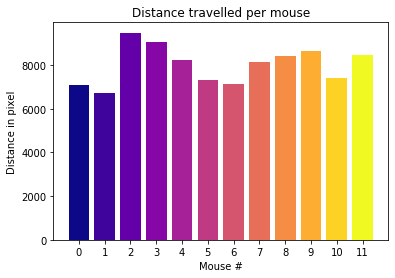

In [25]:
def calculate_distance(pos_df, fn, colormap):
    
    number_of_mice = round(len(pos_df.columns)/2)
    
    x_rows = pos_df[pos_df.columns[pos_df.columns.str.startswith('x')]]
    y_rows = pos_df[pos_df.columns[pos_df.columns.str.startswith('y')]]

    x_rows_diffs = x_rows.diff().abs()
    y_rows_diffs = y_rows.diff().abs()
    y_rows_diffs.columns = [f"x{i}" for i in range(number_of_mice)]
    
    result = x_rows_diffs.combine(y_rows_diffs, lambda x,y: (x**2+y**2)**0.5).sum()
    result.index = [str(i) for i in range(number_of_mice)]

    result.to_csv(f"files/{fn}_total_distance.csv")
    
    
    # Plot it
    colormap = cm.get_cmap(colormap)
    colors = colormap(np.linspace(0, 1, number_of_mice))
    ind = np.arange(number_of_mice)
    fig = plt.figure()
    plt.bar(ind, result, color=colors)
    plt.xticks(ind, [str(i) for i in range(number_of_mice)])
    
    plt.xlabel("Mouse #")
    plt.ylabel("Distance in pixel")
    plt.title("Distance travelled per mouse")
    plt.savefig(f"graphs/{fn}_distance.png")
    
calculate_distance(pos_df, short_fn, colormap)

# <u><center> Average speed in window graph</center></u>
## This graph shows the development of the speed over the time. The speed is calculated by taking the average over a certain time window. The size of this time window can be adjusted by the variable "time_window_in_sec".
![example_speed](pics/example_speed.png)

In [27]:
time_window_in_sec = 20

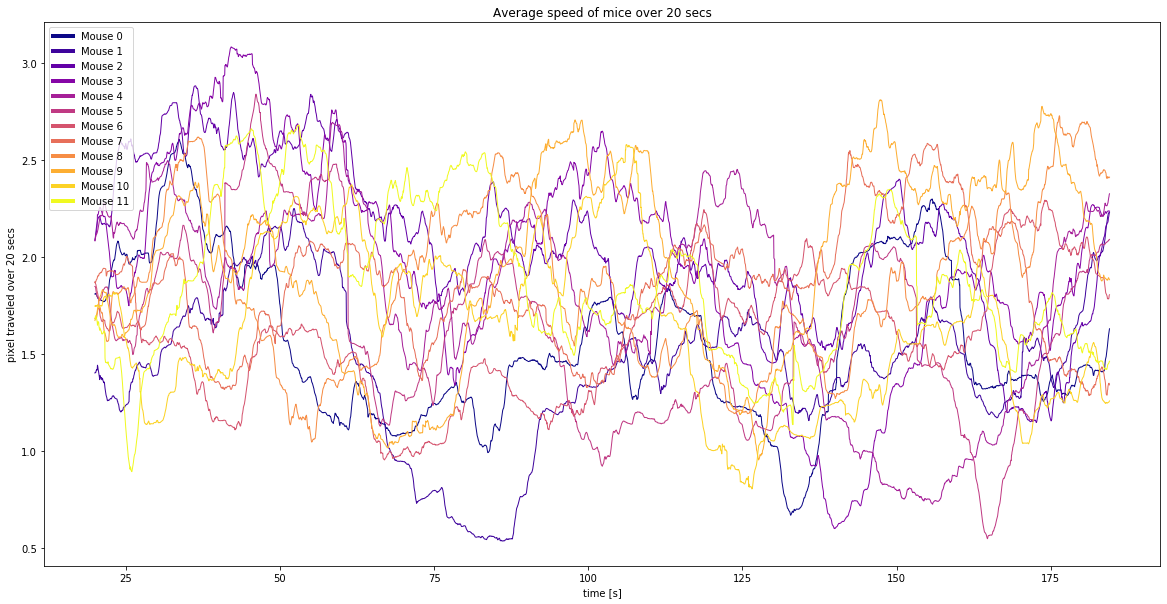

In [28]:
def calculate_speed(pos_df, fn, colormap, framerate, window_seconds):
    
    number_of_mice = round(len(pos_df.columns)/2)
    
    x_rows = pos_df[pos_df.columns[pos_df.columns.str.startswith('x')]]
    y_rows = pos_df[pos_df.columns[pos_df.columns.str.startswith('y')]]

    x_rows_diffs = x_rows.diff().abs()
    y_rows_diffs = y_rows.diff().abs()
    y_rows_diffs.columns = [f"x{i}" for i in range(number_of_mice)]
    
    
    result = x_rows_diffs.combine(y_rows_diffs, lambda x,y: (x**2+y**2)**0.5)
    
    def calc_vel(x):

        return x.mean()
    
    roller = result.rolling(window=round(window_seconds * frame_rate)).apply(calc_vel).dropna()
    roller.columns = [str(i) for i in range(number_of_mice)]
    roller.to_csv(f"files/{fn}_average_speed_over_{window_seconds}_sec.csv")

    # Plot it
    colormap = cm.get_cmap(colormap)
    colors = colormap(np.linspace(0, 1, number_of_mice))
    ind = np.arange(number_of_mice)
    fig = plt.figure(figsize=(20,10))
    for counter,mouse in enumerate(roller.columns):
        
        plt.plot(roller.index/framerate, roller[mouse], color=colors[counter], linewidth=1)
    custom_lines = [Line2D([0],[0], color=colors[i], lw=4) for i in range(len(colors))]
    plt.legend(custom_lines, [f"Mouse {i}" for i in range(number_of_mice)])

    plt.xlabel("time [s]")
    plt.ylabel(f"pixel traveled over {window_seconds} secs")
    plt.title(f"Average speed of mice over {window_seconds} secs")
    plt.savefig(f"graphs/{fn}_speed.png")
    
calculate_speed(pos_df, short_fn, colormap, frame_rate, time_window_in_sec)

# <u><center> Visited areas heat map </center></u>
## The heat maps show the probability where each animal stayed. You can chose another colormap here. A good colormap for heatmaps are for example "Blues" or "Reds".
![example_speed](pics/example_area_heatmap.png)

In [29]:
colormap = "Blues"

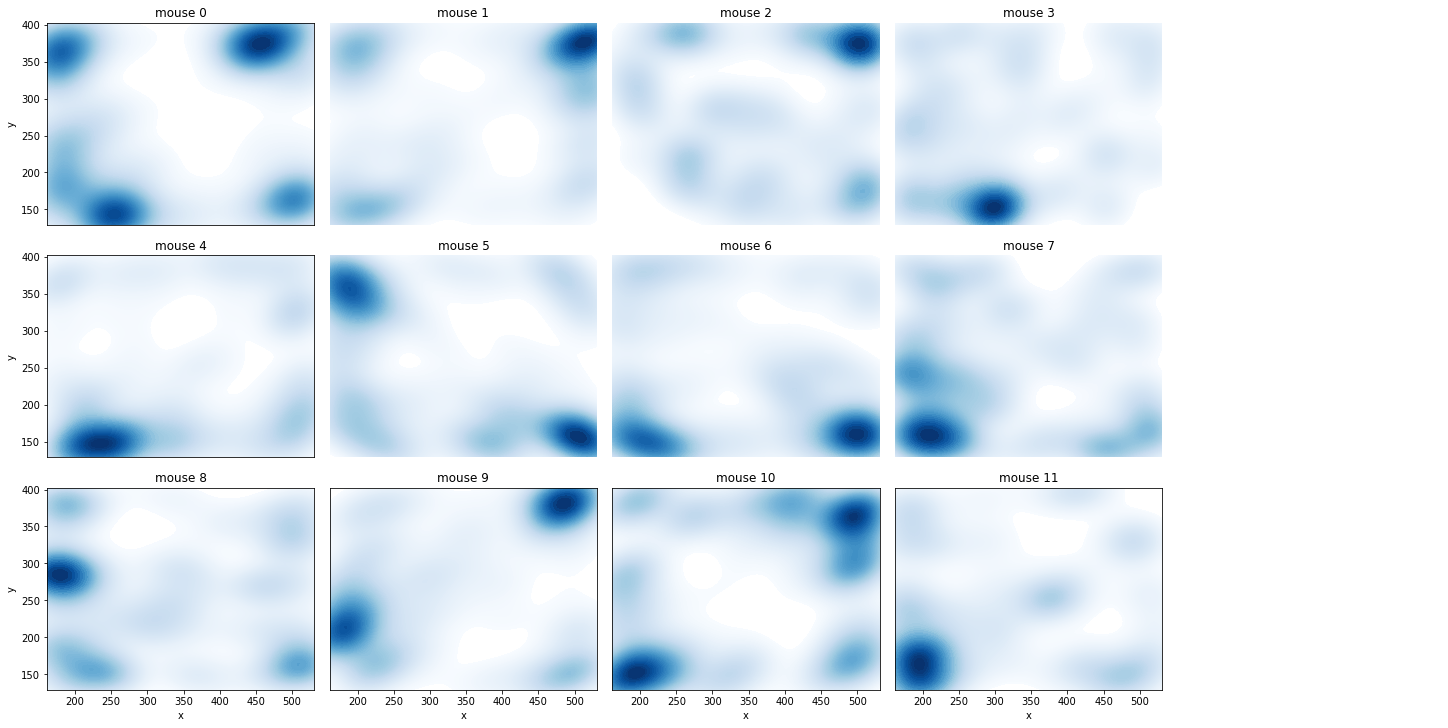

In [31]:
def most_visited_area(pos_df, fn, cmap):
    number_of_mice = round(len(pos_df.columns)/2)

    
    x_rows = pos_df[pos_df.columns[pos_df.columns.str.startswith('x')]]
    y_rows = pos_df[pos_df.columns[pos_df.columns.str.startswith('y')]]
    
    x_min = x_rows.min().min()
    x_max = x_rows.max().max()
    y_min = y_rows.min().min()
    y_max = y_rows.max().max()
    
    
    number_of_rows = int(number_of_mice**0.5)
    if number_of_mice%number_of_rows != 0:
        number_of_cols = int(number_of_mice/number_of_rows) + 1
    else:
        number_of_cols = round(number_of_mice/number_of_rows)
    fig1 = plt.figure(constrained_layout=True, figsize=(20,10))
    gs1 = gridspec.GridSpec(ncols=number_of_cols + 1 , nrows=number_of_rows, figure=fig1)
    axes1 = []
    
    for x_name,y_name, i in zip(x_rows.columns, y_rows.columns, range(len(y_rows.columns))):
        axes1.append(fig1.add_subplot(gs1[int(i/number_of_cols), i%number_of_cols]))
    # load the coordinates file
    #x, y = np.loadtxt('coords.txt', unpack=True)
        x = x_rows[x_name]
        y = y_rows[y_name]
    # call the kernel density estimator function
        sn.kdeplot(x=x,y=y, cmap=cmap, shade=True, thresh=0.05, n_levels=100, gridsize=100, ax=axes1[-1])
    
        if int(i/number_of_cols) == number_of_rows -1 and i%number_of_cols == 0:
            axes1[-1].set_xlabel('x')
            axes1[-1].set_ylabel("y")
        elif int(i/number_of_cols) == number_of_rows -1 :
            axes1[-1].set_xlabel('x')
            axes1[-1].get_yaxis().set_visible(False)
        elif i%number_of_cols == 0:

            axes1[-1].set_ylabel("y")
            axes1[-1].get_xaxis().set_visible(False)
        else:
            axes1[-1].axis('off')
        axes1[-1].set_xlim(x_min, x_max)
        axes1[-1].set_ylim(y_min, y_max)
        axes1[-1].set_title(f"mouse {i}")

        
    fig1.savefig(f"graphs/{fn}_prob_area_heatmap.png")

    
    
most_visited_area(pos_df, short_fn, colormap)